# CAR ACCIDENTS IN SWITZERLAND

## The Pizzafels

### Notebook for milestone 3

## Introduction

This notebook presents our analysis of the car accidents in Switzerland over the past years. From the different datasets that could be correlated to the accidents that we found online on the Swiss OpenData platform, we wanted to identify the ones with the highest impact, so as to be able to make predictions for the future and advise the government/the cantons on the matter.

### Important prior note

We tried to keep a clean tracking of the data in English, but it would have been a pain to manually rewrite every French - German - Italian - Romansh (yes, it exists) information in Shakespeare's language. This is why you can see some of the Swiss languages sometimes in our data, for example in the names of the dataframes, or their columns. We are sorry for the inconvenient and we commented it in a way that is hopefully sufficiently clear to understand what is going on even if you solely understand English!

### .Imports

In [155]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import numpy as np
import codecs
import folium
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import normalize

%pylab inline
pylab.rcParams['figure.figsize'] = (20,12)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Clementg20\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['f', 'plot', 'clf']
`%matplotlib` prevents importing * from pylab and numpy



In [156]:
# Plotly is a free library for python (you may pay to use it online)
try:
    import plotly.plotly as py
    import plotly.graph_objs as go
    import plotly.figure_factory as FF
    from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
    init_notebook_mode(connected=True)
    plotly_ready = True
except:
    plotly_ready = False
    print('Please install Plotly for better results')

### .Constants

In [157]:
DATA_FOLDER = 'data_clean'
IS_DATE = re.compile("^[1-2]{1}[0-9]{3}$") #will be useful to detect values that correspond to dates

geo_center_ch = [46.8, 8.23] # Alggi-Alp

CANTON_TOPO_PATH = './ch-cantons.topojson.json'
CANTON_TOPO = json.load(open(CANTON_TOPO_PATH)) #GeoJson file of cantons used in Homework2

PLOT_FOLDER = 'docs/img/plots/'
PLOTLY_FOLDER = 'docs/img/plotly/'
DFLY_FOLDER = 'docs/img/dataframesly/'
DF_FOLDER = 'docs/img/dataframes/'
MAP_FOLDER = 'docs/img/maps/'

### .Useful functions

#### Function to quickly describe a dataframe

In [158]:
def describeDf(df,name="DESCRIPTION",level=2):
    """
    Describe the data. Different levels are possible.
    Level 0: Print the title of the dataset
    Level 1: Name the different columns
    Level 2: Explore the values of each column
    """
    date=[]
    
    # Explore each column of the dataset
    if(level==2):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        print("\n")
        for col in df.columns:
            # Print the attributes of each column
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                print("         ATTRIBUTE: "+col)
                print("   "+str(df[col].unique()))
                print("\n")
            else:
                date.append(col)
        # Print the years we have information on
        print("         VALUES: "+str(date))
        print("\n\n\n")
        return
    
    # Recover and print the columns of the datasets
    elif(level==1):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        val = []
        # Print the different columns
        for col in df.columns:
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                val.append(col)
        print(val)
        print("\n\n\n")
        return
    
    # Simply print the name of the dataset
    elif(level==0):
        print("   >  " + name+"\n")
    
    # Sanity check: the given level does exist
    else:
        raise NotImplementedError

#### Function to restrict the dataframe to a fix period in term of years

We need this function as our different datasets are often based on different yearly periods.

In [159]:
def get_period(df, start=None,end=None):
    """
    Function to keep the columns of interest of a dataset, between a starting and an ending date.
    """
    columns_to_keep = []
    dates = []
    
    # Go through the columns
    for elem in df.columns:
        # If it is not a date we keep it
        if not IS_DATE.match(elem):
            columns_to_keep.append(elem)
        # Else we store it to see later if we keep it
        else:
            dates.append(int(elem))
    
    # Define the starting and ending dates in the case they are not
    if start == None:
        start = np.min(dates)
    if end == None:
        end = np.max(dates)
    
    # Only keep the columns of interest
    for date in dates:
        if (date<=end) & (date>=start):
            columns_to_keep.append(str(date))
    
    return df[columns_to_keep]

#### Function to get the age corresponding to the intervals as input

Using this functions will allow us to treat people between 40 and 50 years old as one group for example. Again, this is needed because of the disparity among the datasets, with some of them considering each age category differently, while others  groupped the people in different intervals. This functions allow us to compare and work with those different datasets.

In [160]:
def map_int_to_age(k,age_max):
    """
    Transform an integer to what is define as an age, i.e. 20 to '20 ans' ('20 years old')
    """
    if(k != 1 and k<age_max):
        return '{} ans'.format(k)
    if(k == 1):
        return '{} an'.format(k)
    if(k==age_max):
        if (age_max == 100):
            return '{} ans ou plus'.format(age_max)
        else:
            return '{} ans et plus'.format(age_max)

In [161]:
def build_age(intervals,age_max):
    """
    INPUT:  intervals: Array corresponding to the delimitation of the wanted intervals.
            age_max: The maximal age to consider.
    """
    ages_total = []
    
    # Build the intervals
    for i in range(len(intervals)-1):
        ages = []
        
        # We keep the first limit of the interval as its first element: this will
        # allow us to identify the different intervals later
        ages.append(intervals[i])
        
        # Put the corresponding ages in the interval
        for k in range(int(intervals[i]),int(intervals[i+1])):
            # Use our function
            age = map_int_to_age(k,age_max)
            ages.append(age)
            if(k==100):
                break
                
        # Store the interval we just created
        ages_total.append(ages)
    
    return ages_total

#### Mapping for the cantons

One recurrent problem we encountered, as presented in introduction, is the fact that different datasets have information in different languages. In general, we can treat them case by case, but it becomes a major issue when it comes to the Swiss cantons. As we wanted to do an in depth analysis and comparison of them, we needed to be able to refer them in different datasets.

We thus decided to build a dictionnary of every different mentioning of the cantons we found, with a little function to get the corresponding key, allowing us to compare cantons in different datasets.

In [162]:
dict_cantons = dict()
dict_cantons['AA'] = ['Appenzell Rh.-Ext.','Appenzell Ausserrhoden','AR']
dict_cantons['AG'] = ['Argovie','Aargau']
dict_cantons['AI'] = ['Appenzell Rh.-Int.','Appenzell Innerrhoden']
dict_cantons['BE'] = ['Berne', 'Bern', 'Bern / Berne']
dict_cantons['BL'] = ['Bâle-Campagne','Basel-Landschaft']
dict_cantons['BS'] = ['Bâle-Ville','Basel-Stadt','Bâle-Ville   2)','Bâle-Ville  2)']
dict_cantons['FR'] = ['Fribourg', 'Fribourg / Freiburg']
dict_cantons['GE'] = ['Genève', 'Genf']
dict_cantons['GL'] = ['Glaris', 'Glarus']
dict_cantons['GR'] = ['Grisons', 'Graubünden', 'Grigioni', 'Grischun', 'Graubünden / Grigioni / Grischun']
dict_cantons['JU'] = ['Jura']
dict_cantons['LU'] = ['Lucerne', 'Luzern']
dict_cantons['NE'] = ['Neuchâtel']
dict_cantons['NW'] = ['Nidwald', 'Nidwalden']
dict_cantons['OW'] = ['Obwald', 'Obwalden']
dict_cantons['SG'] = ['St. Gall', 'St. Gallen','Saint-Gall']
dict_cantons['SH'] = ['Schaffhouse', 'Schaffhausen']
dict_cantons['SO'] = ['Soleure', 'Solothurn']
dict_cantons['SZ'] = ['Schwytz', 'Schwyz']
dict_cantons['TE'] = ['Tessin', 'Ticino','TI']
dict_cantons['TG'] = ['Thurgovie', 'Thurgau']
dict_cantons['UR'] = ['Uri']
dict_cantons['VS'] = ['Valais', 'Wallis', 'Valais / Wallis']
dict_cantons['VD'] = ['Vaud']
dict_cantons['ZG'] = ['Zoug', 'Zug']
dict_cantons['ZH'] = ['Zurich', 'Zürich']


def getKeysByValue(dictOfElements, valueToFind):
    '''
    Find the key of a canton.
    '''
    for item  in dictOfElements.items():
        if valueToFind==item[0]:
            return valueToFind
        if valueToFind in item[1]:
            return item[0]
            break
    raise NotImplementedError

We also implemented the following function to change all the cantons names to their key

In [163]:
def clean_cantons_names(x):
    clean = x.copy()
    for cant in clean['canton'].unique():
        # Check if what is recorded as a 'canton' really is a canton, i.e. is in our
        # dictionary (this doesn't keep the Swiss totals for example)
        try:
            getKeysByValue(dict_cantons, cant)
        # If not, we don't keep the rows with those 'cantons'
        except:
            clean = clean[clean.canton!=cant]

    # Replace the cantons name by their keys to compare them below
    clean['canton'] = [getKeysByValue(dict_cantons, cant) for cant in clean['canton']]
    
    return clean

And the list of the cantons keys to be able to put every dataframe in the same order

In [164]:
list_cantons_keys = []
for key in dict_cantons.keys():
    list_cantons_keys.append(key)

#### Function to plot a set of data

In [165]:
if plotly_ready != True:
    def plot_dataframe(x, y=None, title=None, xlabel=None, ylabel=None, labels=None,\
                       rotation=0, number_to_plot=None, bars=None,name_save=None):
        if number_to_plot == None:
            try:
                number_to_plot = y.shape[0]
            except:
                pass
        if bars == None:
            plt.figure(figsize=(12,7))
            for j in range(number_to_plot):
                plt.plot(x, y.iloc[j], label = labels[j])
        else:
            x.plot(kind=bars, figsize=(12,7))
        plt.title(title, fontsize=18)
        plt.legend(fontsize=10, loc=0, bbox_to_anchor=(1,1))
        plt.xticks(rotation=rotation, fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel(ylabel, fontsize=15)
        if (name_save!=None):
            plt.savefig(PLOT_FOLDER+name_save+'.png')
        plt.show()
else:
    def plot_dataframe(x, y=None, title=None, xlabel=None, ylabel=None, labels=None,\
                   rotation=0, number_to_plot=None, bars=None,name_save=None):
        if number_to_plot == None:
            try:
                number_to_plot = y.shape[0]
            except:
                pass
        traces = []
        if bars == None:
            for j in range(number_to_plot):
                traces.append(go.Scatter(x=x, y=y.iloc[j].values,name=str(labels[j])))

        else:
            traces.append(go.Bar(y=x.index.values, x=[d[0] for d in x[::-1].values],orientation = 'h'))

        layout = go.Layout(
            title='<b>'+title+'</b>',
            titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f',

                ),
            xaxis=dict(
                title=xlabel,
                titlefont=dict(
                    family='Courier New, monospace',
                    size=15,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title=ylabel,
                titlefont=dict(
                    family='Courier New, monospace',
                    size=15,
                    color='#7f7f7f'
                )
            )
        )

        fig = go.Figure(data=traces,layout=layout)
        iplot(fig)
        if name_save!=None:
            plot(fig,filename=PLOTLY_FOLDER+name_save+'.html',auto_open=False)
        
    

#### Function to scatter plot correlations

In [166]:
if plotly_ready != True:
    def plot_correlation(x, y, title=None, xlabel=None, ylabel=None, labels=None,\
                       rotation=0, number_to_plot=None,name_save=None):
        if number_to_plot == None:
            try:
                number_to_plot = y.shape[0]
            except:
                pass
        plt.figure(figsize=(12,7))
        for j in range(number_to_plot):
            plt.scatter(x.iloc[j], y.iloc[j], label = labels[j])
        plt.title(title, fontsize=18)
        plt.legend(fontsize=10, loc="best", bbox_to_anchor=(1,1))
        plt.xticks(rotation=rotation, fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel(ylabel, fontsize=15)
        if (name_save!=None):
            plt.savefig(PLOT_FOLDER+name_save+'.png')
        plt.show()
else:
    def plot_correlation(x, y, title=None, xlabel=None, ylabel=None, labels=None,\
                   rotation=0, number_to_plot=None,name_save=None):
        if number_to_plot == None:
            try:
                number_to_plot = y.shape[0]
            except:
                pass
        traces = []
        for j in range(number_to_plot):
            traces.append(go.Scatter(x=x.iloc[j].values,y=y.iloc[j].values,\
                                     name=labels[j],mode = 'markers'))
        layout = go.Layout(
            title=title,
            titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                ),
            xaxis=dict(
                title=xlabel,
                titlefont=dict(
                    family='Courier New, monospace',
                    size=15,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title=ylabel,
                titlefont=dict(
                    family='Courier New, monospace',
                    size=15,
                    color='#7f7f7f'
                )
            )
        )
        fig = go.Figure(data=traces,layout=layout)
        iplot(fig,filename='test_output/test.html')
        if name_save!=None:
            plot(fig,filename=PLOTLY_FOLDER+name_save+'.html',auto_open=False)
    

#### Function to save results in order to put in the datastory

In [182]:
def save_it(data, name):
    if (type(data) == type(pd.DataFrame())):
        if plotly_ready != True:
            with codecs.open(DF_FOLDER+name+'.html','w',"utf-8") as f: 
                f.write(data.to_html())
                return
        else:
            sample_data_table = FF.create_table(data,index=True)
            plot(sample_data_table,filename=DFLY_FOLDER+name+'.html',auto_open=False)
            return
    if (type(data) == type(NewMap())):
        data.save(MAP_FOLDER+name+".html")
        return
    raise NotImplementedError

#### Homemade rewriting of the folium

Since the `choropleth` method in folium is depreciated and doesn't display the `NaN values` right, we decide to add a new function to folium to make choropleth map.

In [168]:
import branca
from folium.folium import color_brewer, StepColormap

class NewMap(folium.Map):

    def color_map(self, data, columns, topo_data, objects,
                  legend=None, all_columns = None, layer_name ='', color_domain=[], fill_opacity=0.8, nan_opacity=0.3,
                  line_weight=1, line_opacity=1, key_on='id',show=True, multiMap=False):

        """
        data: dataframe
        columns: tuple of the column headers of the keys and the data to be used
        topo_data: topojson file
        objects: objects path of your topo json file
        layer_name: Name of the color layer. Put 'None' if you don't want to print any 
                    legend
        color_domain: list of the color scale in legend, it is automatically defined with
                        the minimum and maximum of your data if no list is provided.
        multiMap: bool that informs wether it is possible to change the map interactively or not,
                        if yes, we want that both maps plotted interactively use the same color scale
        """
        
        # Fix the color scale: from yellow to red in our case

        if all_columns == None:
            all_columns = [columns[1]]
                # only for interactive maps with two input choices
        lowLim=min( [min(data[all_columns[i]]) for i in range(0,len(all_columns))])   #we select overall min of both sets for the min of color scale
        upLim=max([max(data[all_columns[i]]) for i in range(0,len(all_columns))])    #same for max value of color scale
        colorscale = branca.colormap.linear.YlOrRd_09.scale(lowLim,upLim)
        
        # Redefine the styling function to blacken the NAN entries and color the other 
        # entries with the right color
        def style_function(feature):
            variation = (data[data[columns[0]] == feature[key_on]][columns[1]].values)
            try:
                return {
                    'weight': line_weight,
                    'opacity': line_opacity,
                    'fillOpacity': fill_opacity,
                    'color': 'black',
                    'fillColor': colorscale(variation)
                }
            except:
                return {
                'weight': line_weight,
                'opacity': line_opacity,
                'fillOpacity': nan_opacity,
                'color': 'black',
                'fillColor': '#black'
                }

        # Define the colored layer using the predefine styling function
        geo_json = folium.TopoJson(topo_data,
                                   objects,
                                   style_function = style_function,
                                   name = layer_name,
                                   show=show
                                  )
        
        # Add the colored layer to our map
        self.add_child(geo_json)

        # If you want a color scale legend, add it
        if legend != None:
            
            # If the scale is not defined, define it automatically through the minimal
            # and maximal values
            if not color_domain:
                color_domain = np.arange(lowLim, upLim,(upLim-lowLim)/10)
                
            # Create the legend with the existing function
            brewed = color_brewer('YlOrRd', n=len(color_domain)-1)
            color_scale = StepColormap(
            brewed[0:len(color_domain)-1],    
            index=color_domain,
            vmin=color_domain[0],
            vmax=color_domain[-1],
            caption=legend,
            )
            
            # Add the legend to the map
            self.add_child(color_scale)

#### Function to create a map
Easy function to transform a dataframe with cantons to a map

In [169]:
def create_map(dataframe,columns,legend,column_canton='canton'):
    layerControl = True
    if (type(columns)!=type([])):
        columns=[columns]
        layerControl = False
    MAP = NewMap(geo_center_ch,  zoom_start=8, tiles='cartodbpositron')
    show = True
    for elem in reversed(columns):
        MAP.color_map(data=dataframe,
                      columns=[column_canton, elem],
                      all_columns=columns,
                      topo_data=CANTON_TOPO,
                      objects='objects.cantons',
                      layer_name = str(elem),
                      legend=legend,
                    show=show)
        show = False
        legend = None
    if layerControl:
        folium.LayerControl().add_to(MAP)
    return MAP

### .Datasets Loading

As mentioned, to perform our analysis, we took many datasets from the Swiss OpenData website. All these datasets are excels spreedsheet in differents forms, we hence needed to do a pre-treatment to transform them into clear `csv`
 files. They are stored in the folder `data_clean`.

The pre-treatment was huge since the datasets were sometimes split into multiple spreedsheets (on for each year) for example. Moreover, the excel files were organized to be visually good looking, with many merged cells and various hierachical levels in the data, thus requiring more work to clean and ready it for the future processings with pandas. 

#### Snapshot of our different datasets

In [170]:
dataframes = {}
print("  DATAFRAMES AVAILABLES:\n")

for file in os.listdir(DATA_FOLDER):
    # Load the filename
    filename = os.fsdecode(file)
    # Name the corresponding DataFrame "df_....."
    tablename = "df_"+os.path.splitext(os.path.splitext(filename)[0])[0]
    # Load the values in the DataFrame
    globals()[tablename] = pd.read_csv(DATA_FOLDER + '/' + filename)
    try:
        globals()[tablename] = globals()[tablename].drop(columns=['Unnamed: 0'])
    except:
        pass
    # Print the title of the datasets
    describeDf(globals()[tablename], name=tablename,level=0)
    dataframes[tablename] = globals()[tablename] 

  DATAFRAMES AVAILABLES:

   >  df_Accident_cantons

   >  df_Accident_circonstances

   >  df_Accident_objets

   >  df_Accident_type_route

   >  df_Accident_victimes

   >  df_Besoin_sante

   >  df_Depense_menages_canton

   >  df_Frais_routes_cantonales

   >  df_Frais_routes_communales

   >  df_Frais_routes_nationales

   >  df_hacked_accident

   >  df_Longueur_routes

   >  df_Population_2010

   >  df_Population_age_1992

   >  df_Population_canton_1992

   >  df_Proportion_permis

   >  df_Qualite_vie_agglo

   >  df_Recettes_routes

   >  df_Voitures



# ANALYSIS

## 1. Accidents in Switzerland: A description

### 1.1. Who?

#### 1.1.1 Sex and age 

In this part, we work with the dataset `df_Population_2010`, which records the population by canton, sex and age between 2010 \& 2017. We change the disposition of the dataframe and group it by age and sex for each year. We then consider `df_Population_Age_1992` to have access to the population by age and sex between 1992 \& 2010 and put it in the same form. 

This will allow us to perform a normalization of the number of accidents (by 10'000 people in that case) to have an insight on the more dangerous categories of people.

##### Sex and age of the population on a yearly basis

2010-2017

In [171]:
# Build the age intervals corresponding to the ones in 'df_Accident_objets' with our function
ages = build_age(df_Accident_objets.age_index.unique(),100)

# Group the population by the age intervals to be considered
df_Population_2010_trancheAge = df_Population_2010.copy()
for age in ages:
    # Sum the population of each age in the interval considered and indexing the column
    # by the index of each interval (the number stored at position 0)
    df_Population_2010_trancheAge[str(age[0])] =\
            df_Population_2010_trancheAge.loc[:,age[1:]].sum(axis=1)

# Define the columns of the dataframe we want to keep, i.e. the population for each interval
# of ages, the corresponding year and the sex
toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
toKeep.append('annee')
toKeep.append('sexe')

# We are only interested in the total Swiss population independant of the marital status
# We also delete the rows containing the sum of both men and women
df_pop_Suisse =\
        df_Population_2010_trancheAge[(df_Population_2010_trancheAge['canton'] == 'Suisse')\
                    & (df_Population_2010_trancheAge.etat_civil == "Etat civil - Total")\
                    & (df_Population_2010_trancheAge['sexe'] != 'Sexe - Total')]

# We only keep the wanted columns
df_pop_Suisse = df_pop_Suisse[toKeep]

# Group by year and sex and transpose the dataframe to have each sex & age category
# as a new row and the corresponding years as the different columns
df_pop_Suisse['annee'] = df_pop_Suisse['annee'].map(int).map(str)
df_pop_Suisse = df_pop_Suisse.groupby(['annee','sexe']).sum()
df_pop_Suisse = df_pop_Suisse.transpose()
df_pop_Suisse.index = df_pop_Suisse.index.map(float)

1992-2010

In [172]:
# Delete the rows corresponding to the totals of the different age and sex categories
df_pop_Suisse_1992 = df_Population_age_1992[(df_Population_age_1992.sexe != 'Sexe - Total')\
                                        & (df_Population_age_1992.age != 'Age - Total')]

# Group by sex and age and compute the corresponding population
df_pop_Suisse_1992 = df_pop_Suisse_1992.groupby(['age','sexe']).sum().transpose()

# As before, we create the wanted age intervals
for age in ages:
    # For the different sexes
    for s in df_Population_age_1992[df_Population_age_1992.sexe != 'Sexe - Total'].sexe.unique():
        # Get the columns corresponding to the ages in the interval and the wanted sex
        # to be able to sum them and get the total corresponding population
        index_to = [(annee,s) for annee in age[1:]]
        # Sum the population of each age in the interval considered and indexing the column
        # by the index of each interval (the number stored at position 0)
        df_pop_Suisse_1992[(str(age[0]),s)] = df_pop_Suisse_1992.loc[:,index_to].sum(axis=1)

# Trick to redefine the age as unique column index
df_pop_Suisse_1992 = df_pop_Suisse_1992.transpose().reset_index().set_index('age').transpose()

# Keep only the columns interesting us, i.e. the different intervals
toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
df_pop_Suisse_1992 = df_pop_Suisse_1992[toKeep]
# Transpose the data to have it in the same form as df_pop_Suisse
df_pop_Suisse_1992 = df_pop_Suisse_1992.transpose()

C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:979: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



Merge both datasets

In [173]:
# From 1992 to 2010
for year in range(1992,2010):
    # For each sex
    for sexe in np.unique([sexe[1] for sexe in df_pop_Suisse.columns.values]):
        # Insert the population corresponding to the tuple
        df_pop_Suisse[(str(year),sexe)] =\
                    df_pop_Suisse_1992.loc[df_pop_Suisse_1992.sexe==sexe][str(year)]

##### Number of accidents normalized for each category

In [174]:
df_Accident_objets_normalized = df_Accident_objets.copy()

# Delet the accident for which the sex or age is unknown
df_Accident_objets_normalized =\
            df_Accident_objets_normalized[(df_Accident_objets_normalized.sexe_index!=9)\
                                          &(df_Accident_objets_normalized.age_index != 999)]

# Go through each year, sex and age category of the population and normalize the number
# of accident by 10'000 people
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        # At each corresponding location, normalize by the corresponding population
        df_Accident_objets_normalized.loc[(df_Accident_objets_normalized.age_index==age) &\
                                           (df_Accident_objets_normalized.sexe==sexe),year]\
        = df_Accident_objets_normalized[year]*10000 /\
                            df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

In [183]:
# We only consider the private vehicles accidents where there was a mistake from the driver
df_conducteur = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                        & (df_Accident_objets_normalized.voiture_index==210)]

# Group by sex and age as wanted, sum the number of accidents and sort them to see which 
# category had the biggest impact in 2017, and keep the columns interesting us, i.e. the years
df_conducteur = df_conducteur.groupby(['sexe','age']).sum().\
        sort_values(['2017'], ascending=False)\
        [[col for col in df_conducteur.columns if IS_DATE.match(col)]]

# Plot the top 5 categories with our homemade function
plot_dataframe(x=df_conducteur.columns.values, y=df_conducteur.head(5),\
               title='Yearly accident for the top 5 categories', xlabel='Year',\
               ylabel="Accidents per 10'000 people", labels=df_conducteur.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_sexe&age_top5')

print("Number of accident for different sexe and age for 1/10.000 inhabitants in Switzerland\n\
for the interesting categories:")
df_display = df_conducteur.loc[[('Homme', '20 ans'), ('Homme', '18-19 ans'),
       ('Homme', '21-29 ans'), ('Femme', '20 ans'),
       ('Homme', '30-39 ans'), ('Femme', '21-29 ans'),
       ('Homme', '70 ans et plus'),
       ('Homme', '15-17 ans'), ('Homme', '10-14 ans'),
       ('Homme', '6-9 ans'), ('Femme', '10-14 ans'),
       ('Femme', '15-17 ans')],['1992', '2017']]

display(df_display)
save_it(df_display,'accident_sexe&age')

Number of accident for different sexe and age for 1/10.000 inhabitants in Switzerland
for the interesting categories:


1992       2017
sexe  age                                  
Homme 20 ans          127.971524  39.736442
      18-19 ans        91.262445  35.445563
      21-29 ans        79.562532  28.468726
Femme 20 ans           41.204299  25.532472
Homme 30-39 ans        43.852580  21.087092
Femme 21-29 ans        30.755826  19.821769
Homme 70 ans et plus   27.131433  19.782825
      15-17 ans         4.312239   0.534870
      10-14 ans         2.423276   0.047569
      6-9 ans           0.062282   0.000000
Femme 10-14 ans         0.746233   0.000000
      15-17 ans         1.575920   0.000000

As expected, young people are still the ones to have the most accidents in 2017. Men are in particular responsible of more incidents than women, except apparently between 21 and 29 years old, which is the only time we find them having more accidents than men of the same age interval. After the young people, we actually find the very old ones, with men that are 70 years old and more. But they still have half less accidents than young men aged 20.

We can interestingly see that more than 1 in 20'000 men is involved in an accident before 18 years old ! Back 25 years ago, some boys even younger than 10 years old were involved in car incidents.

If we now compare the records of 2017 with the ones from 1992, we see a drastical decrease, which was to be expected with the numerous improvements observed around the security of travelers, including the improvements of the cars themselves, but also the stricter rules of today. The decrease is more marked for young people, the number of accidents dropped of 2/3 for men aged 20!

Nicely, we can see that women did not have any accident before the legal age to drive a car in Switzerland, i.e. 18 years old, in 2017, which wasn't the case 25 years earlier.

From the first plot, we can identify a very good progress since the early 2000's for the entire population.

##### Taking the number of people actually posessing a driver license into account

Now that we know the accidents for each age & sex category, it is interesting to take into account the fact that not every man-woman posesses a driver license. However, we are confronted to the usual problem: the dataset containing this new information is built differently, as can be seen below. The age categories are different, and not all the years are represented.

In [184]:
display(df_Proportion_permis)
save_it(df_Proportion_permis,'proportion_permis')

,critere,1994,2000,2005,2010,2015
0,Total,76.1925,79.5684,81.4970,80.8099,81.5869
1,Hommes,86.7108,88.6161,89.1752,87.8091,87.9242
2,Femmes,66.2318,71.0744,74.4214,74.4154,75.5780
3,18-24 ans,70.7393,68.7840,62.7032,58.6586,60.9546
4,25-64 ans,84.8314,87.8657,89.5716,89.3944,88.8073
5,65 ans et plus,44.2482,53.2861,61.7433,64.0817,69.2718


In general, we can note an increase in the proportion of people with a driver license. 

An interesting conclusion comes from the fact that not that many young people posess a license, and yet they are responsible for a lot of accidents. Sadly, since the age intervals are not defined like before and are very vague, we cannot really perform an analysis on them. However, it is to notice that if we did, we would see an even greater gap between younger and older people: young people have more accidents per 10'000 people but less have a driver license. This means that they will have even more accidents per 10'000 people posessing a license!

Given the lack of information of this dataset again (the information on the sexes is aggregated and only present for a few years), we can only restrain our analysis on the accidents by sexes for the 5 years in the data.

In [185]:
# Get the total accident for men and women for the years interesting us
df_conducteur_sexe = df_conducteur.groupby('sexe').sum()\
    [['1994', '2000', '2005', '2010', '2015']]

# Make the indices plural to match the ones of the other dataset
df_conducteur_sexe = df_conducteur_sexe.transpose().add_suffix('s').transpose()

# Get the proportion of men and women having a license
df_proportion_sexe = df_Proportion_permis.iloc[1:3].set_index('critere')

# Scale the data given the proportion of people with a license
df_conducteur_sexe_scaled = df_conducteur_sexe/df_proportion_sexe*100

# Custom the indices
df_conducteur_sexe_scaled = df_conducteur_sexe_scaled.transpose().add_prefix('Pondéré ').transpose()

# Concatenate the dataframes to plot them
df_conducteur_sexe_scaled = df_conducteur_sexe_scaled.append(df_conducteur_sexe)

# plot the results with our function
plot_dataframe(x=df_conducteur_sexe_scaled.columns.values, y=df_conducteur_sexe_scaled,\
               title='Yearly accident for men and women', xlabel='Year',\
               ylabel="Accidents per 10'000 people",\
               labels=df_conducteur_sexe_scaled.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_driver_sexe')

Since the proportion of women having a license hase always been below the one for men, the impact is higher for them. However, even with this scaling, we can still say that women are more cautious with cars with 150 accidents for 10'000 drivers in 2017 against 228 for men. But the gap was still reduced over the last years and men might catch up one day.

#### 1.1.2 Driver Licence

How long had the people in an accident had their license for? In this analysis, we start again from the normalized total of accidents that we created before, i.e. normalized by each 10'000 of people (without taking care of the proportions of driving people as this did not carry enough interesting information). 

We also take the years of license from the `df_Accident_objects` dataset. Note that they are groupped by interval sometimes (e.g. 6-10 years).

In [186]:
index_permis = df_Accident_objets['annee_permis_index'].unique()

# Create a mapping to know how many years are accounted for in each interval
mapping={}
for i in range(len(index_permis)-1):
    if (index_permis[i]==16):
        mapping[index_permis[i]] = 64 # Until 80 years old
    else:
        mapping[index_permis[i]] = index_permis[i+1] - index_permis[i] 

# Focus our analysis on the accidents of tourism cars when there was a mistake and drop
# the cases where we don't know for how many years the license was hold
df_permis = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                            & (df_Accident_objets_normalized.voiture_index==210)\
                            & (df_Accident_objets_normalized.annee_permis!='Inconnu')]

# Group by the different categories
df_permis = df_permis.groupby(['annee_permis','annee_permis_index']).sum()

# Rescale the values: divide the total of accidents by the number of different ages
# of the intervals (assumption: if you consider people with 6-10 years of license ther
# will be approximately 5 times more people than if only one year is taken into account)
for i in range(len(df_permis.index)):
    df_permis.loc[df_permis.index.values[i]] = df_permis.loc[df_permis.index.values[i]]/\
                                                    mapping[df_permis.index.values[i][1]]

# Get the years for which we have information and sort them (reference: 2017)
df_permis = df_permis.sort_values(['2017'], ascending=False).reset_index()\
        [['annee_permis']+[col for col in df_permis.columns if IS_DATE.match(col)]].\
        set_index('annee_permis')

# Plot the results with our function
plot_dataframe(x=df_permis.columns.values, y=df_permis[:6],\
               title='Time after obtention of the driving license', xlabel='Year',\
               ylabel="Accidents per 10'000 people",\
               labels=df_permis.index.values[:6],\
               rotation=45, number_to_plot=None,name_save='accident_driving_licence')

# Plot the results but the top 3 lines with our function
plot_dataframe(x=df_permis.columns.values, y=df_permis.iloc[3:],\
               title='Time after obtention of the driving license (experienced drivers)', xlabel='Year',\
               ylabel="Accidents per 10'000 people",\
               labels=df_permis.iloc[3:].index.values,\
               rotation=45, number_to_plot=None,name_save='accident_driving_licence_experienced')

In general, the results are as expected: throughout both plots, one can easily see that the more experienced the people are, the less accidents they provoque. As before, and especially for new drivers, we observe a kind of pick in the early 2000's, but the tendency has been clearly decreasing in the past years.

Only one confirmed drivers (more than 3 years, as the law is now defined in Switzerland) in a thausend has an accident. Note that the results for the category '16 years and more' are probably twisted: we decided to say the people could drive until 80 years old. The point is that the amount of accidents that category causes is the smallest.

##### Illgeal drivers

We start again from our normalized set of before, assuming that the people for which we don't have any information about how much time they have had a driving license for simply didn't have any.

In [187]:
# Without driver licence
df_conducteur_illegal = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized.voiture_index==210)\
                                             &(df_Accident_objets_normalized.annee_permis_index==999)]
df_conducteur_illegal = df_conducteur_illegal.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]

plot_dataframe(x=df_conducteur_illegal.columns.values, y=df_conducteur_illegal.head(),\
               title='Yearly accident for people without driver licence', xlabel='Year',\
               ylabel="Accidents per 10'000 people",\
               labels=df_conducteur_illegal.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_illegal_driver')

##### A zoom on the victims

In [188]:
# Compute the total of accidents for each consequence type and role of
# the vicims, keep the columns interesting us: the years
req = df_Accident_victimes.groupby(['consequence','role']).sum()

# Display the results
display(req[['1992', '2017']])
save_it(req[['1992', '2017']],'victims')


1992     2017
consequence  role                        
Blessé grave Conducteur   5254.0   2780.0
             Passager     1351.0    297.0
             Piéton       1239.0    577.0
Blessé léger Conducteur  14214.0  13199.0
             Passager     4929.0   2869.0
             Piéton       1696.0   1691.0
Tué          Conducteur    518.0    156.0
             Passager      168.0     27.0
             Piéton        148.0     47.0

We can see the expected drop in the number of victims in 25 years. In the print above, we can clearly distinguish a difference between the pedestrian victims and the ones in the cars. The pedestrian are indeed not protected by the car, the security of which has been greatly improved. We can note that the number of pedestrian victims hasn't had quite the same drop as the other victims.

##### Analysis of the pedestrian victims

Again, we firstly standardize our data by the population (by 10'000 people) to get a meaningful insight. We make use of the population dataset we created above to save computational time

In [189]:
df_Accident_victimes_normalized = df_Accident_victimes.copy()

# Keep the acidents for which the sex and age were known
df_Accident_victimes_normalized = df_Accident_victimes_normalized\
        [(df_Accident_victimes_normalized['sexe_index']!=9) &\
         (df_Accident_victimes_normalized.age_index != 999)]

# Normalization for each age, sex and year
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        df_Accident_victimes_normalized.loc[(df_Accident_victimes_normalized.age_index==age) &\
                                           (df_Accident_victimes_normalized.sexe==sexe),year]\
        = df_Accident_victimes_normalized[year]*10000 / df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

In [190]:
# Compute the number of pedestrian victims by age category, sort them (reference
# year: 2017) and keep the wanted columns: the years
req = df_Accident_victimes_normalized[(df_Accident_victimes_normalized.role=='Piéton')]. \
                    groupby(['age']).sum().sort_values(['2017'], ascending=False) \
                    [[col for col in req.columns if IS_DATE.match(col)]]

# Print the 5 age categories with the most accidents in 2017
display(req[['1992', '2017']].head())
save_it(req[['1992', '2017']].head(),'pedestrian_victims')

,1992,2017
age,,
15-17 ans,7.717780,10.733823
20 ans,5.600790,9.837047
10-14 ans,10.698540,9.755883
6-9 ans,25.644259,9.501137
5 ans,22.415872,9.165600


Interestingly, and quite sadly, we can see that the young people are the prior pedestrian victims. It even increased since 1992 for people between 15 and 20 years old. However, it clearly dropped for younger children, which is consolating.

In [191]:
# Compute the number of pedestrian deaths by age category, sort them (reference
# year: 2017) and keep the wanted columns: the years
req = df_Accident_victimes_normalized[(df_Accident_victimes_normalized.role=='Piéton')\
                        & (df_Accident_victimes_normalized.consequence_index==320.0) ].\
                        groupby(['age']).sum().sort_values(['2017'], ascending=False)\
                            [[col for col in req.columns if IS_DATE.match(col)]]

# Print the 5 age categories leading to the most deaths in 2017
display(req[['1992', '2017']].head())
save_it(req[['1992', '2017']].head(),'pedestrian_victims_death')


,1992,2017
age,,
70 ans et +,2.379670,0.390141
60-69 ans,0.635827,0.174291
18-19 ans,0.119444,0.114424
jusqu'à 4 ans,0.145923,0.091718
21-29 ans,0.117233,0.079749


Interestingly, the categories are now completely different! Older people are more likely to die from an accident: they are indeed involed in less accidents while resulting in more deaths. We also sadly find very young children in the top 5 of the deadliest categories.

### 1.2. Where?

#### 1.2.1. Road type

In this section, we will analyze on which tpe of road the accidents happended. They are separated in three categories, i.e. accidents in localities, out of them or on the highway.

In [192]:
# Get the 'rurality' of the accidents by summing all the accidents by type of road
# Keep the interesting columns, i.e. the different years
req = df_Accident_type_route.groupby(['ruralite']).sum().\
        sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]

# Plot the accidents by road type with our function
plot_dataframe(x=req.columns.values, y=req, title='Road type', xlabel='Year',\
               ylabel='Number of accidents', labels=req.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_road_type')

In general, we can see a decrease of the number of accidents throughout the years. This tenency was also observed above. It is less marked here but one must remember that the data is not normalized here: the number of people on the roads increased while the number of incidents still decreased.

We are in particular interested in the amount of accidents leading to deaths. Below, we analyze the proportion of incidents (in %) with tragic consequences.

In [193]:
# Get the yearly total of accidents on each road type
total_accident = df_Accident_type_route.groupby(['ruralite']).sum()\
        [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]

df_Accident_type_route_normalized_ruralite = df_Accident_type_route.copy()

# Get the percentage of each category of accidents for each year and road type
for ruralite in total_accident.index.values:
    for year in total_accident.columns:
        df_Accident_type_route_normalized_ruralite.\
        loc[df_Accident_type_route_normalized_ruralite.ruralite==ruralite,year]=\
            df_Accident_type_route_normalized_ruralite.\
            loc[df_Accident_type_route_normalized_ruralite.ruralite==ruralite][year]*100/\
            total_accident.loc[total_accident.index==ruralite,year][0]

# We are interested in the deadly accidents on a yearly basis, grouped by the different
# road types.
req = df_Accident_type_route_normalized_ruralite\
        [df_Accident_type_route_normalized_ruralite.gravite_index==317].\
        groupby(['ruralite']).sum().sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]

# Plot the results with our function
plot_dataframe(x=req.columns.values, y=req,\
               title='Proportion of accidents leading to death', xlabel='Year',\
               ylabel='Percentage', labels=req.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_proportion_leading_death')

We can see the proportion of deadly accidents has been dropping during the last 25 years. This corroborates our previous affirmation: the securtiy of the drivers has been seriously improved.

#### 1.2.2 Road conditions

We can also take a look at the conditions and the speed limit of the roads on which the accidents happened.

In [194]:
df_Accident_type_route_normalized = df_Accident_type_route.copy()

# Transform the data in percentages along the year
for date in [col for col in df_Accident_type_route_normalized.columns if IS_DATE.match(col)]:
    df_Accident_type_route_normalized[date]=\
        df_Accident_type_route_normalized[date]*100/\
        (df_Accident_type_route_normalized[date].sum())

# Group the accidents by road condition and keep the useful columns
req = df_Accident_type_route_normalized.groupby(['temps']).sum().\
    sort_values(['2017'], ascending=False)\
    [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
# Plot the results with our function
plot_dataframe(x=req.columns.values, y=req,\
               title='Accidents for the different road conditions', xlabel='Year',\
               ylabel='Percentage', labels=req.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_road_condition')

# This time without considering the accidents happening when the road is dry
req = df_Accident_type_route_normalized[df_Accident_type_route_normalized.temps!='Sec'].\
    groupby(['temps']).sum().sort_values(['2017'], ascending=False)\
    [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
# Plot the results with our function
plot_dataframe(x=req.columns.values, y=req,\
               title="Road condition when the road wasn't dry", xlabel='Year',\
               ylabel='Percentage', labels=req.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_road_condition_undry')

# We can also look at the speed limits of the roads where accidents happened
req = df_Accident_type_route_normalized.groupby(['vitesse']).sum().\
    sort_values(['2017'], ascending=False)\
    [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
# And plot it with our usual function
plot_dataframe(x=req.columns.values, y=req,\
               title="Speed limits on the roads where accidents happened", xlabel='Year',\
               ylabel='Percentage', labels=req.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_speed_limit')

We can see that the vast majority of the accidents are happening on dry roads. This might be unexpected and point towards the fact that the people are less careful when the conditions seem ideal. If the road is not dry, then most incidents happen in wet or damp conditions, which is not very surprising.

Most of the incidents happened on roads limited at between 40 and 50 km/h, i.e. inside localities. They are probably not the deadliest ones but are surely numerous due to the high number of external factors that can impact the driver and cause an accident. We can see an increase in accidents on roads limited below 30 km/h, which might be due to the growing number of those roads appearing in the cities.

#### 1.2.3 Cantonal analysis

This part describes the main dataset that we plan to use in the scope of a 'canton-scale comparative study'. Since we have an **aggregated** dataset of car accidents in cantons, the possibility of correlations within the dataset are limited. 

##### Absolute number of accidents

We start from the `df_Accident_canton` containing the number of accidents on different road types and with different gravities for each canton on a yearly basis. As usual, we sort them based on the reference year 2017.

In [195]:
# Delete the row that doesn't contain any information
df_Accident_cantons = df_Accident_cantons.dropna()
df_Accident_cantons = clean_cantons_names(df_Accident_cantons)
# Compute the total accidents per canton, sort them and keep the wanted columns
df_cantons = df_Accident_cantons.groupby(['canton']).sum().\
        sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident_cantons.columns if IS_DATE.match(col)]]

# As an example, plot the 5 cantons with the most accidents
plot_dataframe(x=df_cantons.columns.values, y=df_cantons.head(5),\
               title="The 5 cantons with the most accidents", xlabel='Year',\
               ylabel='Number of accidents', labels=df_cantons.head(5).index.values,\
               rotation=45, number_to_plot=None,name_save='accident_canton_top5')

The results are hard to compare due to the different characteristics of the cantons. They are a lot of accidents in Zürich, but this should be dampened by the high population. They are also quite a lot of accident in Geneva and Vaud but both have a very different area. 

To get a more meaningful insight on the number of accidents in each canton, we identified and found data on 2 key features that we think should impact the number of accidents: the road length and the population in the cantons.

In [196]:
# See it on a map
MAP = create_map(df_cantons.reset_index(),[d for d in df_cantons.columns if IS_DATE.match(d)],'Number of accidents')
save_it(MAP,'accident_canton')

#### <center>[CLICK HERE TO SEE THE MAPS](./docs/_stories/maps/accident_canton.html)</center>

##### Normalization by road length

For this, we use the `df_Longueur_routes` dataset, which records the kilometers of road in each canton and some regions for each year since 1992 and until 2016. Note that this implies the reference year becomes 2016. For visualization purposes, we record the number of accidents per 100 km.

In [197]:
df_cantons_routes = df_Longueur_routes.copy()

# Since we are only interested in the cantonal values, we can delete the row with
# information on the regions
for elem in df_cantons_routes['canton'].unique():
    # Check if what is recorded as a 'canton' really is a canton, i.e. is in our
    # dictionary
    try:
        getKeysByValue(dict_cantons, elem)
    # If not, we don't keep the rows with those 'cantons'
    except:
        df_cantons_routes =\
        df_cantons_routes[df_cantons_routes.canton!=elem]

# Replace the cantons name by their keys to compare them below
df_cantons_routes['canton'] =\
        [getKeysByValue(dict_cantons, canton) for canton in\
                     df_cantons_routes['canton']]

# Get the number of accidents by canton from before, until 2016
df_cantons_normalized_km = df_cantons.drop(['2017'],axis=1).copy().reset_index()

# Replace the cantons name by their keys to compare them with the other set
df_cantons_normalized_km['canton'] =\
        [getKeysByValue(dict_cantons, canton) for canton in\
                        df_cantons_normalized_km['canton']]

# Set the canton as index
df_cantons_normalized_km = df_cantons_normalized_km.set_index('canton')

# Normalization: get through the cantons and the year to normalize
for canton in df_cantons_normalized_km.index:
    for date in df_cantons_normalized_km.columns:
        df_cantons_normalized_km.loc[canton,date]=\
        100*df_cantons_normalized_km.loc[canton,date]/\
        df_cantons_routes[(df_cantons_routes.canton == canton) \
                        & (df_cantons_routes.annee==int(date))]['Total'].values[0]
        
# Sort the cantons for 2016
df_cantons_normalized_km = df_cantons_normalized_km.sort_values('2016', ascending=False)

# Plot the top 5 cantons with this normalization
plot_dataframe(x=df_cantons_normalized_km.columns.values,\
               y=df_cantons_normalized_km.head(5),\
               title="The 5 cantons with the most accidents per 100 km", xlabel='Year',\
               ylabel='Number of accidents per 100 km',\
               labels=df_cantons_normalized_km.head(5).index.values,\
               rotation=45, number_to_plot=None,name_save='accident_canton_per100km')

# Get rid of the two ouliers
plot_dataframe(x=df_cantons_normalized_km.columns.values,\
               y=df_cantons_normalized_km.iloc[2:7],\
               title="Without BS and GE, two outliers", xlabel='Year',\
               ylabel='Number of accidents per 100 km',\
               labels=df_cantons_normalized_km.iloc[2:7].index.values,\
               rotation=45, number_to_plot=None,name_save='accident_canton_per100km_nooutlier')

In [198]:
df_cantons_normalized_km[23:]

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
VS,19.945042,20.901939,18.798024,19.055430,17.005901,17.491946,17.873762,17.044913,19.214265,18.132734,...,15.216301,14.117478,14.335806,14.054312,13.458790,13.220581,11.862792,12.624157,12.028678,11.152593
SH,10.434135,9.377717,12.234505,11.179430,10.730679,10.233827,10.416021,9.486019,12.459707,12.211753,...,12.338025,10.228118,10.290107,8.245505,9.113453,10.415375,9.164087,10.092879,9.783282,10.525012
JU,13.776138,15.194390,12.118602,13.407134,13.030117,11.800860,12.904398,13.752575,13.146735,12.298558,...,10.320478,9.656588,9.596234,9.354255,8.965102,8.844765,6.919374,9.604486,9.843107,7.970497


With this normalization, the results are as expected. Small cantons basically consisting in one big town (Basel-Town and Geneva, Zug) have the most accidents. Bigger and rural cantons present a smaller number of accidents: we find Valais and Jura among the three cantons with the least accidents per 100km.

In [199]:
# On the map
MAP = create_map(df_cantons_normalized_km.reset_index(),[d for d in df_cantons_normalized_km.columns if IS_DATE.match(d)][-1:],'Number of accidents per 100km')
save_it(MAP,'accident_canton_normalized')

#### <center>[CLICK HERE TO SEE THE MAPS](./docs/_stories/maps/accident_canton_normalized.html)</center>

In [200]:
# On the map
MAP = create_map(df_cantons_normalized_km.iloc[2:].reset_index(),[d for d in df_cantons_normalized_km.columns if IS_DATE.match(d)],'Number of accidents per 100km')
save_it(MAP,'accident_canton_normalized_nooutlier')

#### <center>[CLICK HERE TO SEE THE MAPS](./docs/_stories/maps/accident_canton_normalized_nooutlier.html)</center>


##### Relative variations of accidents

In [201]:
df_cantons_variation = df_cantons.copy()
for i in reversed(range(1993,2018)):
    df_cantons_variation[str(i)] = (df_cantons_variation[str(i)]-df_cantons_variation[str(i-1)])*100/df_cantons_variation[str(i-1)]
df_cantons_variation = df_cantons_variation.drop(['1992'],axis=1)

In [202]:
MAP = create_map(df_cantons_variation.reset_index(),[d for d in df_cantons_variation.columns if IS_DATE.match(d)],'Relative variation compare to the previous year')
save_it(MAP,'accident_canton_variations')

#### <center>[CLICK HERE TO SEE THE MAPS](./docs/_stories/maps/accident_canton_variations.html)</center>


##### Proportion of fatal accident (with death people)

In [203]:
dates = [d for d in df_Accident_cantons.columns if IS_DATE.match(d)]
df_proportion_death_canton = 100*df_Accident_cantons[df_Accident_cantons.gravite_index==317].groupby('canton').sum()[dates]/df_Accident_cantons.groupby('canton').sum()[dates]
df_proportion_death_canton = df_proportion_death_canton.sort_values(['2017'], ascending=False)

# Plot the top 5 cantons with this caracteristic
plot_dataframe(x=df_proportion_death_canton.columns.values,\
               y=df_proportion_death_canton.head(5),\
               title="The 5 cantons with the higher proportion of fatal accident", xlabel='Year',\
               ylabel='Proportion of fatal accident',\
               labels=df_cantons_normalized_km.head(5).index.values,\
               rotation=45, number_to_plot=None,name_save='accident_canton_death')
df_proportion_death_canton = clean_cantons_names(df_proportion_death_canton.reset_index())

In [204]:
MAP = create_map(df_proportion_death_canton,[d for d in df_proportion_death_canton.columns if IS_DATE.match(d)],'Proportion of fatal accident')
save_it(MAP,'accident_canton_death')

#### <center>[CLICK HERE TO SEE THE MAPS](./docs/_stories/maps/accident_canton_death.html)</center>


### 1.3. When?

In this section, we try to analyze the time of the day, day of the week and month when the accidents happened. We base ourselves on the dataset `df_hacked_accident`, which was named like that because the data we retrieved from a Swiss OpenData's API. It contains information about every accident between 2011 and 2017

##### Daily analysis

In [205]:
# Compute the number of accidents per weekday, rename the index and the columns
df_day = df_hacked_accident[['accidentday', 'id']].\
    groupby('accidentday')[['id']].count().\
    reindex(['lundi','mardi','mercredi','jeudi','vendredi','samedi','dimanche']).\
    rename(columns = {'id' : 'accidents'})

# Plot the results
plot_dataframe(x=df_day[::-1], title="Number of accidents per weekday",\
               xlabel='Number of accidents', ylabel='Weekday', bars='barh',name_save='accident_weekday')

The only two outliers are the Fridays and the Sundays. The latter probably follows from the fact that the people move less on Sunday, the 'family day'. It seems like a lot of accidents happen on Fridays, which might be a consequence of the excitment around the coming week end (and of the beer after work ;)).

Cantonal analysis:

In [206]:
# Group by cantons and weekday to get the number of accidents and create a
# dataframe with the cantons as indices and the weekdays as columns
df_day_canton = df_hacked_accident[['accidentday','canton', 'id']].\
        groupby(['accidentday', 'canton']).count().reset_index().\
        pivot(index='canton', columns='accidentday', values='id')

# Get the worst day for each canton and then compute the number of cantons
# for which each weekday was the worst
worst_day_canton = pd.DataFrame(df_day_canton.idxmax('columns').reset_index()).\
        groupby(0).count()

# Append Tuesday and Sunday that wouldn't appear in the plot otherwise and
# profit to rename the data for a better plot below
worst_day_canton = worst_day_canton.\
    append(pd.DataFrame({'canton' : pd.Series([0, 0], index=['mardi', 'dimanche'])})).\
    reindex(df_day.index).rename(columns = {'canton' : 'nb cantons'})

# Plot the results with our function
plot_dataframe(x=worst_day_canton[::-1], title="Worst day for the cantons",\
               xlabel='Number of cantons', ylabel='Weekday', bars='barh',name_save='accident_canton_weekday')

If we only look at this plot, it looks like the end of the week is tiring for people, almost every canton seems to have more accidents between Thursdays and Saturdays.

##### Hourly analysis

In [207]:
# Compute the number of accidents per hour and weekday, create a table,
# rename the index and transpose it for the plot below
df_hour = df_hacked_accident[['accidentday', 'accidenthour', 'id']].\
    groupby(['accidentday', 'accidenthour']).count().reset_index().\
    pivot(index='accidenthour', columns='accidentday', values='id').\
    reindex(columns = df_day.index).dropna(axis=0).transpose()

# Plot the results
plot_dataframe(x=df_hour.columns, y=df_hour, labels=df_hour.index,\
               title="Hour of accidents per weekday",\
               xlabel='Hour of the day', ylabel='Number of accidents',name_save='accident_hour_weekday')

# Plot the results for typical days
plot_dataframe(x=df_hour.columns, y=df_hour[4:], labels=df_hour.index[4:],\
               title="Special days", xlabel='Hour of the day',\
               ylabel='Number of accidents',name_save='accident_special_day')

Apart from Saturdays and Sundays, we can see a very interesting pattern: all the week days are more or less following the exact same distribution! We identify two picks: one in the morning and one between 17h and 19h: this corresponds to the starting and ending working hours and is as expected. We can see a little bit more accidents on Fridays, corroborating our previous observations.

Concerning the weekends, when people don't work, the patterns are clearly different, the two picks corresponding to the work hours disappeared and we observe less accidents in general. However, we see more of them in the early hours of the day, probably explained by the end of Fridays and Saturdays night.

##### Monthly analysis

In [208]:
# Compute the number of accidents per month, define the index and
# rename the column for the plot below 
df_month = df_hacked_accident[['accidentmonth', 'id']].\
    groupby(['accidentmonth']).count().reindex(index=\
    ['janvier','février','mars','avril','mai','juin','juillet',\
     'août','septembre','octobre','novembre','décembre']).\
    rename(columns={'id':'Accidents'})
    
# Plot the results
plot_dataframe(x=df_month, bars='bar', title="Accidents by month",\
               xlabel='Month', ylabel='Number of accidents',\
               rotation=45,name_save='accident_month')

Surprisingly, we observe far more accidents in Summer, we the roads should be safer. We can thus imagine that the peole aren't carful enough during that time of the year.

We can also take a look at the evolution through the years. For it to be interesting, we use here another dataset conaining monthly information, but from 1992: `df_Accident_circonstances`. We can retrieve the months with the most accidents for each year and plot it to see the evolution.

In [245]:
if plotly_ready != True:
    # Number of months to plot for each year
    months_to_plot = 2

    # Group by month and only keep the biggest values
    monthly_basis = df_Accident_circonstances.groupby('mois_index').sum().\
            reset_index().apply(lambda x: x.nlargest(months_to_plot))
    # Plot the results (we cannot use our function here)
    plt.figure(figsize=(12,7))
    for month in range(monthly_basis.shape[0]):
        to_plot = monthly_basis.iloc[month].values[6:]
        # Check if there is something to plot: this will control the labels and
        # not print the names of the months that don't appear in the plot
        if len(to_plot[np.isnan(to_plot)==False]) != 0:
            # Scatter plot, where the months indices are transformed to strings
            plt.scatter(np.arange(1992,2018,1), monthly_basis.iloc[month].values[6:],\
                label=datetime.date(1900, int(monthly_basis.index[month]+1), 1).strftime('%B'))
    # Customization
    plt.title('Accidents by month for the {} months with the most accidents each year'.\
              format(months_to_plot), fontsize=23)
    plt.legend(fontsize=10, loc="best", bbox_to_anchor=(1,1))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Number of accidents', fontsize=15)
    plt.savefig(PLOT_FOLDER+'accident_2months'+'.png')
    plt.show()
else:
    # Plot the results (we cannot use our function here)
    traces = []
    for month in range(monthly_basis.shape[0]):
        to_plot = monthly_basis.iloc[month].values[6:]
        # Check if there is something to plot: this will control the labels and
        # not print the names of the months that don't appear in the plot
        if len(to_plot[np.isnan(to_plot)==False]) != 0:
            # Scatter plot, where the months indices are transformed to strings
            traces.append(go.Scatter(x=np.arange(1992,2018,1),y=monthly_basis.iloc[month].values[6:],name=datetime.date(1900, int(monthly_basis.index[month]+1), 1).strftime('%B'),mode = 'markers'))
    # Customization
    layout = go.Layout(
            title='Accidents by month for the {} months with the most accidents each year'.\
              format(months_to_plot),
            titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                ),
            xaxis=dict(
                title='Year',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=15,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title='Number of accidents',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=15,
                    color='#7f7f7f'
                )
            )
        )
    init_notebook_mode(connected=True)
    fig = go.Figure(data=traces,layout=layout)
    iplot(fig)
    plot(fig,PLOT_FOLDER+'accident_2months'+'.html',auto_open=False)



The months appearing in the plos above are what we expected: months from the Summer period. We see the usual pick in the early 2000's and a general decrease.

> This dataset might provide some relevant outcomes regarding the decision makers (drivers and/or walkers)

> One more time, since decision makers want to minimize the number of victims, some outcoming correlations between the vehicle type and the accidents for example might be useful in our study. 

### 1.4 Why?

Let's take a look at the different reasons explaining the accidents (except for the road conditions that were analyzed before). We start again from our 'hacked' dataset, and it provides information about the exact circumstances of the accidents.

In [210]:
# Get the accidents for each recorded circumstance, sort them to have a nice plot
# Rename the column and one index to facilitate the plot below
df_circumstance = df_hacked_accident[['accidenttype', 'id']].groupby('accidenttype').\
    count().sort_values('id').rename(columns = {'id' : 'nb accidents'},\
    index={"accident lors d'un dépassement ou lors d'un changement de voie de circulation":\
           'dépacement ou changement de voie'})

# Plot the results
plot_dataframe(x=df_circumstance, bars='barh', title="Circumstances of the accidents",\
               xlabel='Number of accidents', ylabel='Circumstance',name_save='accident_circumstances')

We can see that the three first circumstances are losses of control, collisions and accidents while entering a road. The incidents involving pedestrians come just after. It is interesting to see that most accidents seem to arise from individual mistakes from the drivers.

Let's take a closer look at the biggest reason behind accidents: skids (losses of control).

In [211]:
# get the accidents interesting us, keep only the corresponding month and count them
# Rename the column and put the rows in order of the months for the plot
df_derapage = df_hacked_accident\
    [df_hacked_accident.accidenttype == 'dérapage ou perte de maîtrise']\
    [['accidentmonth', 'id']].groupby('accidentmonth').count().\
    rename(columns = {'id':'Nb accidents'}).\
    reindex(index=['janvier','février','mars','avril','mai','juin','juillet',\
                   'août','septembre','octobre','novembre','décembre'])

# Plot the results using our function
plot_dataframe(x=df_derapage, bars='bar', title="Skids leading to accidents",\
               xlabel='Month', ylabel='Number of accidents',name_save='accident_skid_month')

Surprisingly, we can see that more acidents linked to skids happen in the Summer time, which is quite counterintuitive ! Again, it lookd like people are less careful when there is no snow on the road, leading to less accidents even if the conditions in themselves are worse.

Another interesting thing to do is to explore the substances taken by the drivers in the case of accidents. This is what do below, starting from `df_Accident_circonstances`, which record those substances from 1992 to 2017

In [212]:
df_substances = df_Accident_circonstances.groupby('circonstance').sum()\
    [[col for col in df_Accident_circonstances.columns if IS_DATE.match(col)]].\
    sort_values('2017', ascending=False)

plot_dataframe(x=df_substances.columns, y=df_substances[:3],\
               labels=df_substances[:3].index,\
               title="Substances discovered if any", xlabel='Year',\
               ylabel='Number of accidents', rotation=45,name_save='accident_substances')

plot_dataframe(x=df_substances.columns, y=df_substances[1:4],\
               labels=df_substances[1:4].index,\
               title="Known substances", xlabel='Year',\
               ylabel='Number of accidents', rotation=45,name_save='accident_known_substances')

plot_dataframe(x=df_substances.columns, y=df_substances[2:],\
               labels=df_substances[2:].index,\
               title="Known substances except alcohol alone", xlabel='Year',\
               ylabel='Number of accidents', rotation=45,name_save='accident_substances_noalcool')

We can clearly see that most of the accidents were not the consequence of any illegal substance. If we discard those accidents, then the biggest problem in Switzerland is clearly the alcohol. It is still leading to 6 times more accidents than drugs in 2017 and 12 times more than medicines.

Interestingly, the accident with unknown circumstances or ensuing from alcohol have had a decreasing tendency for the last 25 years, but this trend is not observed for all the other substances!

## 2. Correlations focused on cantons-granulated data

As shown above, we have a lot of different information about the Swiss cantons Therefore, we decided to focus on them and base our analysis on the correlations between the different variables have and the accidents.
The following datasets have been selected because they are linked to road safety and good operation, such as investment in road sector, expenses of households in alcool and public transport as well as type of cars prefered in each canton. 

We will identify the most important features corrolated to the accidents in Switzerland as a preparation for the part 3 of our project. Below are listed the variables we will consider for this analysis.

For each feature, we plan to measure whether they are correlated to car accidents frequency or not. One approach might be the Pearson coorelation coefficient, however, we could also study if another distribution than normal law is revealed.

### 2.0 Precomputations

As explained before, we had some problems with the fact that the cantons are not labelled the same in every data set. Because of that, we firstly need to change them to their corresponding key so we can identify them. We use our homemade function for this purpose

In [213]:
df_Population_canton_1992 = clean_cantons_names(df_Population_canton_1992)
df_Population_2010 = clean_cantons_names(df_Population_2010)
df_Accident_cantons = clean_cantons_names(df_Accident_cantons)
df_Frais_routes_cantonales = clean_cantons_names(df_Frais_routes_cantonales)
df_Longueur_routes = clean_cantons_names(df_Longueur_routes)

### 2.1 Normalized number of accidents

To get more meaningful insights, it will often be interesting to compare the different variables on a normalized basis. We will thus use the following dataframe where the number of accidents has been normalized by the population of the cantons (by 1000 people). As usual, we sort them with respect to 2017 to get an idea of the current situation.

In [214]:
# Get the victims by canton, drop the uninteresting columns and the last row 
# (which is a row of NaN), group and sum the accidents for the cantons
df_victimes_cantons_normalized = df_Accident_cantons.\
    drop(columns = (['canton_index', 'gravite_index', 'ruralite_index']))[:-1].\
    groupby('canton').sum().sort_values('2017', ascending=False)

# Get the population from 1992 and the interesting columns
df_pop_cantons = df_Population_canton_1992\
    [(df_Population_canton_1992.sexe == 'Sexe - Total')].\
    drop(columns = ['sexe','2010'])

# Get the population from 2010, group by canton and keep what we want
df_pop_cantons_since_2010 = df_Population_2010[(df_Population_2010.sexe == 'Sexe - Total') &\
                            (df_Population_2010.etat_civil == 'Etat civil - Total')]\
    [['annee', 'canton', 'Age - Total']].groupby(['annee','canton']).sum().\
    reset_index().pivot(index='canton', columns='annee', values='Age - Total').\
    rename(columns = lambda x : str(x)[0:4])

# Merge both datasets to have the population by canton from 1992 to 2017
df_pop_cantons = df_pop_cantons.\
    merge(df_pop_cantons_since_2010, left_on='canton', right_on='canton').set_index('canton')

# Normalization of the number of accidents by year and canton
for cant in df_victimes_cantons_normalized.index.values:
    for year in df_victimes_cantons_normalized.columns:
        df_victimes_cantons_normalized.loc[cant][year] =\
            df_victimes_cantons_normalized.loc[cant][year]/\
            df_pop_cantons.loc[cant][year]*1000
        
# Sort them wrt the reference year
df_victimes_cantons_normalized = df_victimes_cantons_normalized.sort_values('2017', ascending=False)

# Plot the 5 cantons with the most accidents per 1000 persons
plot_dataframe(x=df_victimes_cantons_normalized.columns, y=df_victimes_cantons_normalized[:5],\
               labels=df_victimes_cantons_normalized[:5].index,\
               title="Normalized number of accidents ", xlabel='Year',\
               ylabel='Number of accidents', rotation=45,name_save='correlation_normalized')

### 2.2 Expenses for Roads

A first correlation we wanted to examine was with the expenses of the different cantons in the roads (new roads, maintenance, police surveillance, ...). Again, to have a more meaningful insight, we normalize these expenses by the road length of the cantons. Alltogether, this means we corrolate the number of accidents for 1000 people with the expenses for 100 km of road.

Normalization:

In [215]:
df_frais_cantons_normalized = df_Frais_routes_cantonales.copy()

# Sum the different types of expenses (with the police surveillance) in a new column
df_frais_cantons_normalized['Expenses'] =\
    df_frais_cantons_normalized[['Constructions', 'Amélio-', 'Entretien Construction',\
                      'Entretien Exploitation']].sum(axis=1)

# Drop the now useless columns
df_frais_cantons_normalized =\
    df_frais_cantons_normalized[['annee', 'canton', 'Expenses']]

# Create a dataframe with the cantons in index and the years in columns
df_frais_cantons_normalized = df_frais_cantons_normalized.\
    pivot(index = 'canton', columns = 'annee', values = 'Expenses').\
    rename(columns = lambda x : str(x))

# Create a dataframe with the cantons in index and the years in columns for
# the road length
df_routes_cantons =\
    df_Longueur_routes.pivot(index = 'canton', columns='annee', values = 'Total').\
    rename(columns = lambda x : str(x))

# Normalization
for cant in df_frais_cantons_normalized.index.values:
    for year in df_frais_cantons_normalized.columns:
        df_frais_cantons_normalized.loc[cant][year] =\
                    df_frais_cantons_normalized.loc[cant][year]/\
                    df_routes_cantons.loc[cant][year]*100

To analyze the correlations, we need to restrain ourselves to the period between 1994 and 2015, because of the lack of information.

In [216]:
df_victimes_cantons_normalized_toplot = df_victimes_cantons_normalized.copy()

# Drop the uninteresting columns
df_victimes_cantons_normalized_toplot = df_victimes_cantons_normalized_toplot.\
    drop(columns = ['1992', '1993', '2016', '2017'])

# Order the dataframe wrt to 2015
df_victimes_cantons_normalized_toplot =\
    df_victimes_cantons_normalized_toplot.sort_values('2015', ascending = False)

# Order both dataframes to have a 1-1 correspondance between the rows
df_frais_cantons_normalized =\
    df_frais_cantons_normalized.reindex(df_victimes_cantons_normalized_toplot.index)

# Plot with our function
plot_correlation(x = df_frais_cantons_normalized[1:6], y = df_victimes_cantons_normalized_toplot[1:6],\
                title='Correlation wrt. the expenses in the roads', xlabel='Total expenses',\
                ylabel='Number of victimes', labels=df_frais_cantons_normalized.index[1:6],name_save='correlation_expenses_roads')

In [217]:
df_frais_cantons_normalized = df_frais_cantons_normalized.sort_values(['2015'],ascending=False)
MAP = create_map(df_frais_cantons_normalized.iloc[1:].reset_index(),[str(i) for i in df_frais_cantons_normalized.columns],'Expenses in the road')
save_it(MAP,'expenses_road_canton')

#### <center>[CLICK HERE TO SEE THE MAPS](./docs/_stories/maps/expenses_road_canton.html)</center>

We discarded Basel Town in the plot above because it is a clear outlier, with three times as much expenses as any other canton. The five cantons plotted are the one investing the most in the roads.

But we are interested in a possible correlation, so let's investigate it.

In [218]:
# Define our threshold of interest and the wanted confidence
alpha = 0.05
threshold_of_interest = 0.75

print('Significant correlations:')

# Check the correlation coefficient for every canton to keep the interesting ones
low_correlation = []
i = 0
for j in range(26):
    # Pearson coefficient
    pear = pearsonr(df_frais_cantons_normalized.iloc[j,:],\
                    df_victimes_cantons_normalized_toplot.iloc[j,:])
    # If not interesting: store it
    if abs(pear[0]) < threshold_of_interest:
        low_correlation.append(j)
    # If interesting: print the correlation
    if pear[1]< alpha:
        i += 1
        print(i, 'Canton:', df_victimes_cantons_normalized_toplot.index[j], '/ Correlation:', pear[0])
        
# Only keep the interesting cantons for the plot
high_correlation_victims = df_victimes_cantons_normalized_toplot.\
    drop(df_victimes_cantons_normalized_toplot.index[[low_correlation]])
high_correlation_frais = df_frais_cantons_normalized.\
    drop(df_frais_cantons_normalized.index[[low_correlation]])

print('Plot the cantons with a correlation of more than {}:'.format(threshold_of_interest))

# Plot with our function
plot_correlation(x = high_correlation_frais, y = high_correlation_victims,\
                title='Correlation wrt. the expenses in the roads', xlabel='Total expenses',\
                ylabel='Number of victimes', labels=high_correlation_frais.index,name_save='correlation_expenses_roads_zoomin')

Significant correlations:
1 Canton: UR / Correlation: -0.5951243046706516
2 Canton: TE / Correlation: -0.7598514232072192
3 Canton: LU / Correlation: -0.6447528537588436
4 Canton: NW / Correlation: -0.5849549373583104
5 Canton: SO / Correlation: -0.634474793987521
6 Canton: ZH / Correlation: -0.7435246851798258
7 Canton: ZG / Correlation: -0.5104154560476565
8 Canton: BS / Correlation: -0.6885165474628875
9 Canton: SH / Correlation: -0.4724162151011934
10 Canton: SZ / Correlation: -0.6330794907160828
11 Canton: AG / Correlation: -0.6871247074551293
12 Canton: SG / Correlation: -0.4721811579473904
13 Canton: VD / Correlation: -0.7829860253640205
14 Canton: OW / Correlation: -0.4311737575629701
15 Canton: FR / Correlation: -0.5616390950033022
Plot the cantons with a correlation of more than 0.75:


In conclustion, 15 cantons exhibit a significant correlation with respect to their expenses with the defined confidence of 95%. However, Neuchatel shows a slight positive (yet unsignificant) correlation of almost 0.5! In general, since only about half of the cantons show a significant correlation, we cannot really draw any conclusion.

### 2.3 Expenses in the police surveillance on the roads

We can do the exact same analysis but for the expenses related to the police on the roads. Contrary to what was done before however, we normalize the expenses with the population and not the road length: a canton with more budget is supposed to have more police officers.

In [219]:
df_police_cantons_normalized = df_Frais_routes_cantonales.copy()

df_police_cantons_normalized = df_police_cantons_normalized[['annee', 'canton', 'Surveillance Policiere']]

# Create a dataframe with the cantons in index and the years in columns
df_police_cantons_normalized = df_police_cantons_normalized.\
    pivot(index = 'canton', columns = 'annee', values = 'Surveillance Policiere').\
    rename(columns = lambda x : str(x))

# Normalization of the number of accidents by year and canton
for cant in df_police_cantons_normalized.index.values:
    for year in df_police_cantons_normalized.columns:
        df_police_cantons_normalized.loc[cant][year] =\
            df_police_cantons_normalized.loc[cant][year]/\
            df_pop_cantons.loc[cant][year]*1000

As before, we only have data for the period 1994-2015.

In [220]:
df_victimes_cantons_normalized_toplot = df_victimes_cantons_normalized.copy()

# Drop the uninteresting columns
df_victimes_cantons_normalized_toplot = df_victimes_cantons_normalized_toplot.\
    drop(columns = ['1992', '1993', '2016', '2017'])

# Order the data frames wrt to 2015
df_victimes_cantons_normalized_toplot =\
    df_victimes_cantons_normalized_toplot.sort_values('2015', ascending = False)

# Order both dataframes to have a 1-1 correspondance between the rows
df_police_cantons_normalized =\
    df_police_cantons_normalized.reindex(df_victimes_cantons_normalized_toplot.index)

# Plot with our function
plot_correlation(x = df_police_cantons_normalized.head(5), y = df_victimes_cantons_normalized_toplot.head(5),\
                title='Correlation wrt. the expenses in the police', xlabel='Total expenses',\
                ylabel='Number of victimes', labels=df_police_cantons_normalized.head(5).index,name_save='correlation_expenses_police')

In [221]:
df_police_cantons_normalized = df_police_cantons_normalized.sort_values(['2015'],ascending=False)
MAP = create_map(df_police_cantons_normalized.reset_index(),[str(i) for i in df_police_cantons_normalized.columns],'Expenses in the police for road')
save_it(MAP,'expenses_police_canton')

#### <center>[CLICK HERE TO SEE THE MAPS](./docs/_stories/maps/expenses_police_canton.html)</center>

We kept the 5 cantons witht the most investments in the plot. It looks like we can distinguish a negative correlation between the number of victims and the expenses in the police surveillance of the roads.

Again, we are interested to see if we can find any significant correlation for some cantons:

In [222]:
# Define our threshold of interest and the wanted confidence
alpha = 0.05
threshold_of_interest = 0.75

print('Significant correlations:')

# Check the correlation coefficient for every canton to keep the interesting ones
low_correlation = []
i = 0
for j in range(26):
    # Pearson coefficient
    pear = pearsonr(df_police_cantons_normalized.iloc[j,:],\
                    df_victimes_cantons_normalized_toplot.iloc[j,:])
    # If not interesting: store it
    if abs(pear[0]) < threshold_of_interest:
        low_correlation.append(j)
    # If interesting: print tje correlation
    if pear[1] < alpha:
        i += 1
        print(i, 'Canton:', df_victimes_cantons_normalized_toplot.index[j], '/ Correlation:', pear[0])

# Only keep the interesting cantons for the plot
high_correlation_victims = df_victimes_cantons_normalized_toplot.\
    drop(df_victimes_cantons_normalized_toplot.index[[low_correlation]])
high_correlation_police = df_police_cantons_normalized.\
    drop(df_police_cantons_normalized.index[[low_correlation]])

print('Plot the cantons with a correlation of more than {}:'.format(threshold_of_interest))

# Plot with our function
plot_correlation(x = high_correlation_police, y = high_correlation_victims,\
                title='Correlation wrt. the expenses in the police', xlabel='Total expenses',\
                ylabel='Number of victimes', labels=high_correlation_police.index,name_save='correlation_expenses_police_best')

Significant correlations:
1 Canton: UR / Correlation: -0.6349448827780629
2 Canton: TE / Correlation: -0.9005933480813262
3 Canton: NW / Correlation: -0.7632207244954388
4 Canton: SO / Correlation: -0.48177491342295703
5 Canton: JU / Correlation: -0.9236427366827068
6 Canton: ZH / Correlation: -0.7796782682257315
7 Canton: BS / Correlation: -0.6774462094634011
8 Canton: SZ / Correlation: -0.8356879129638443
9 Canton: AG / Correlation: -0.8135470007146359
10 Canton: VD / Correlation: 0.5294873947710823
11 Canton: OW / Correlation: -0.4989251959149544
12 Canton: NE / Correlation: -0.8638707141466356
13 Canton: VS / Correlation: -0.550083185021806
Plot the cantons with a correlation of more than 0.75:


We can see that more cantons exhibit clear negative correlation between the number of victims and their expenses for the police surveillance. With the same confidence of 95% however, only 15 cantons again show any significant correlation, and for Neuchatel and Vaud the correlation is even positive (>0.6 for both !) In general, it is thus hard to draw conclusions and the cantons should probably be treated separately.

### 2.5 Type of cars

Information on the different type of cars in each canton on a yearly basis

In [223]:
# Using df_Voitures
describeDf(df_Voitures)
print('First rows of the dataset:')
display(df_Voitures.head(2))

______________________________ DESCRIPTION ______________________________



         ATTRIBUTE: canton_index
   [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]


         ATTRIBUTE: canton
   ['Zürich' 'Bern / Berne' 'Luzern' 'Uri' 'Schwyz' 'Obwalden' 'Nidwalden'
 'Glarus' 'Zug' 'Fribourg / Freiburg' 'Solothurn' 'Basel-Stadt'
 'Basel-Landschaft' 'Schaffhausen' 'Appenzell Ausserrhoden'
 'Appenzell Innerrhoden' 'St. Gallen' 'Graubünden / Grigioni / Grischun'
 'Aargau' 'Thurgau' 'Ticino' 'Vaud' 'Valais / Wallis' 'Neuchâtel' 'Genève'
 'Jura' 'Confédération']


         ATTRIBUTE: carosserie_index
   [11. 12. 13.]


         ATTRIBUTE: carosserie
   ['Limousine' 'Break' 'Cabriolet']


         ATTRIBUTE: carburant_index
   [ 100.  200.  300. 9900.]


         ATTRIBUTE: carburant
   ['Essence' 'Diesel' 'Electrique' 'Autres']


         ATTRIBUTE: cylindre_index
   [ 1.01399e+05  1.01799e+05  1.01999e+05  1.02499e+05  1.09999e+0

,canton_index,canton,carosserie_index,carosserie,carburant_index,carburant,cylindre_index,cylindre,traction_index,traction,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.0,Zürich,11.0,Limousine,100.0,Essence,101399.0,jusqu'à 1399 cm3,1.0,Traction avant,...,9465.0,9462.0,9364.0,9276.0,9375.0,9315.0,9448.0,9474.0,9881.0,10412.0
1,1.0,Zürich,11.0,Limousine,100.0,Essence,101399.0,jusqu'à 1399 cm3,1.0,Traction avant,...,86546.0,87274.0,91180.0,96187.0,100565.0,105378.0,109020.0,113222.0,115168.0,116336.0


### 2.6 Expenses of citizens

In [224]:
# Using df_Depense_menages_canton
df_Depense_menages_canton.head(2)

,annee,Canton,Mode,Eaux-de-vie,Vins,Bières,"Boissons alcoolisées dans les restaurants, cafés et bars",Boissons alcoolisées en petite restauration,Boissons alcoolisées dans les cantines,Boissons alcoolisées chez des privés lors d'invitations,...,"Motos, scooters et vélomoteurs",Vélos,Carburants et lubrifiants,"Train, billets et abonnements","Tram, billets et abonnements","Bus, billets et abonnements","Bateau, billets et abonnements",Transport multimodal,Services de téléphonie mobile,Assurance véhicule
0,2006–2008,Zurich,Tot,8.238019489450405,56.251273,8.361510,75.590536,6.067617,0.37909465523331387,( ),...,( ),11.510053967140562,141.489994,34.573547,4.047249522742667,3.842554,3.172501021756669,72.360688,64.300854,101.943344
1,2006–2008,Zurich,Pct,0.0008621494018315626,0.005887,0.000875,0.007911,0.000635,3.967412685360722e-05,( ),...,( ),0.0012045839604442686,0.014808,0.003618,0.0004235646394821113,0.000402,0.00033201789115942093,0.007573,0.006729,0.010669


### 2.7 Impact of the health budget

In [225]:
# Using df_Besoin_sante
df_Besoin_sante.head(2)

,annee,canton,Total,Soins hopitaux,Soins domicile,Administration Prevention,besoin_par_habitant
0,1996,Appenzell Rh.-Ext.,38.845225,37.085203,0.176061,1.583962,751.683415
1,1996,Appenzell Rh.-Int.,4.794571,4.155756,0.363790,0.275025,456.258563


### 2.3 Road length

Yearly information about the road network of each canton.

In [226]:
# Using df_Longueur_routes
d = df_cantons_routes.pivot(index = 'canton', columns='annee', values = 'Total')

## 3. Predictions

For the well correlated features (low p Value of uncorrelation hypothesis), we will use a machine learning technique and apply a regression to predict the potential number of car accidents following different possible decisions made in investment and road infrastructure by a canton for example.

In [227]:
# Get datasets with canton
regex_canton = re.compile('.*[C|c]anton.*')
regex_population = re.compile('.*Population.*')
cantons_dfs=[]
for index in dataframes:
    if not regex_population.match(index):
        for col in dataframes[index].columns:
            if regex_canton.match(col):
                if index not in ['df_Depense_menages_canton','df_hacked_accident']:
                    cantons_dfs.append(index)
                break

In [228]:
# Map names of cantons to their index
for df in cantons_dfs:
    globals()[df] = clean_cantons_names(globals()[df])
    globals()[df] = globals()[df].dropna()


In [229]:
# Snapshot of dataframes we get to build features for the ML stuff
annees_max = []
annees_min = []

# We get two type of dataframe : one with a column date for the date, the other one with one colum by date
cantons_dfs_dateASrows = []
cantons_dfs_dateAScolumns = []

# If we want to excluded some dataframe from the analyse
excluded_df = []


for df in [c for c in cantons_dfs if (c not in excluded_df)]:
    print(df)
    try:
        annees_max.append(np.max(globals()[df].annee))
        annees_min.append(np.min(globals()[df].annee))
        
        # Accident is not a feature but what we want to predict
        if(not re.compile('.*[A|a]ccident.*').match(df)):
            cantons_dfs_dateASrows.append(df)
    except:
        annees_df = [int(d) for d in globals()[df].columns if IS_DATE.match(d)]
        annees_max.append(np.max(annees_df))
        annees_min.append(np.min(annees_df))
        if(not re.compile('.*[A|a]ccident.*').match(df)):
            cantons_dfs_dateAScolumns.append(df)

annee_max = int(np.min(annees_max))
annee_min = int(np.max(annees_min))
print("\n\n>>  Information from {} to {}".format(annee_min,annee_max))

df_Accident_cantons
df_Besoin_sante
df_Frais_routes_cantonales
df_Frais_routes_communales
df_Frais_routes_nationales
df_Longueur_routes
df_Recettes_routes
df_Voitures


>>  Information from 1996 to 2015


In [230]:
# Array useful to select interesting years
annees = [d for d in range(annee_min,annee_max+1)]
str_annees = [str(d) for d in annees]

In [231]:
# Dictionnary of dataframe of features by cantons

features_cantons = {}

# Run over the canton
for canton in dict_cantons:
    # Create the dataframe associated
    features_cantons[canton] = pd.DataFrame({'annee':annees})
    
    # Run over the dataframe availables
    for df in cantons_dfs_dateASrows:
        # Run over columns of this dataframe
        for column in globals()[df].columns:
            # Annee and Canton are not feature but parameters
            if (column not in ['annee','canton']):
                
                # Name the feature by the canton involve, the dataframe extract and the column name.
                # The name of the canton is important even if for now we have one dataframe per canton, 
                # after we will merge the dataframes.
                name = canton+'_'+df.split('_',1)[1]+'-'+column
                
                # Get the vector associated
                feature = globals()[df][(globals()[df].canton==canton) & (globals()[df].annee.isin(annees))]\
                            .sort_values('annee')[column].values
                
                # Assigned the vector to dataframe
                features_cantons[canton][name]=feature
                
    # Same thing for dataframe with columns as date
    for df in cantons_dfs_dateAScolumns:
        
        # Total of the dataframe is a feature
        name = canton+'_'+'total_' + df.split('_',1)[1]
        feature = globals()[df][globals()[df].canton==canton].sum()[str_annees].values
        features_cantons[canton][name]=feature
        
        # Select columns with feature get an index
        interesting_features = [c for c in globals()[df].columns if ((re.compile('.*_index').match(c)) and (not re.compile('.*canton.*').match(c)))]
        
        for feature in interesting_features:
            
            # Iteration over different values of the feature
            for i, feature_value in enumerate(globals()[df][globals()[df].canton==canton].groupby(feature).sum()[str_annees].values):
                features_cantons[canton][canton+'_'+feature+'_'+str(i)]=feature_value

            

In [232]:
# What we get for the Zurich canton
features_cantons['ZH'].head(5)

,annee,ZH_Besoin_sante-Total,ZH_Besoin_sante-Soins hopitaux,ZH_Besoin_sante-Soins domicile,ZH_Besoin_sante-Administration Prevention,ZH_Besoin_sante-besoin_par_habitant,ZH_Frais_routes_cantonales-Total,ZH_Frais_routes_cantonales-Constructions,ZH_Frais_routes_cantonales-Amélio-,ZH_Frais_routes_cantonales-Acquisition,...,ZH_cylindre_index_2,ZH_cylindre_index_3,ZH_cylindre_index_4,ZH_cylindre_index_5,ZH_traction_index_0,ZH_traction_index_1,ZH_traction_index_2,ZH_boite_index_0,ZH_boite_index_1,ZH_boite_index_2
0,1996,597.109834,551.936208,14.047492,31.126134,703.336287,140678.0,4197,21751,3500,...,150776.0,130892.0,75661.0,81667.0,367264.0,126317.0,53955.0,156247.0,391289.0,0.0
1,1997,504.605052,458.678150,12.071022,33.855880,630.783492,156813.0,13862,17035,5709,...,148959.0,134042.0,76230.0,85135.0,375212.0,122645.0,55256.0,162697.0,390416.0,0.0
2,1998,479.590000,435.590000,12.050000,31.950000,608.050057,156503.0,13297,19624,4178,...,150328.0,137991.0,78021.0,88090.0,387147.0,120081.0,57244.0,170936.0,393536.0,0.0
3,1999,532.576277,474.037181,13.177087,45.362009,619.001605,180607.0,22933,22824,4154,...,152889.0,141279.0,79264.0,92328.0,398406.0,118141.0,60694.0,179626.0,397615.0,0.0
4,2000,566.148776,511.078457,10.571166,44.499153,654.138309,196619.0,20331,18012,4257,...,154960.0,145607.0,81178.0,96296.0,408370.0,116527.0,65861.0,187898.0,402860.0,0.0


In [233]:
# Get a dictionnary of accident by canton
accidents_cantons = {}

accidents = df_Accident_cantons.groupby('canton').sum()[[d for d in df_Accident_cantons.columns if (IS_DATE.match(d))]]
accidents = accidents[[d for d in accidents.columns if ((int(d) in annees))]]

for canton in dict_cantons:
    accidents_cantons[canton] = accidents[accidents.index==canton].transpose()[canton].values

In [234]:
# Import ML algorithms
from sklearn.tree import DecisionTreeRegressor,export_graphviz,ExtraTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# WARNING

> `DecisionTreeRegressor` are not reproductible. Sometime results are good, sometimes not...

In [235]:
# Dictionnary of algo of ML to test
ML_stuff = {}
ML_stuff['linear'] = LinearRegression()
ML_stuff['ridge'] = Ridge()
ML_stuff['MLP_lbfgs'] = MLPRegressor(solver='lbfgs')
ML_stuff['tree'] = DecisionTreeRegressor()
ML_stuff['extra_tree'] = ExtraTreeRegressor()
ML_stuff['forest'] = RandomForestRegressor()

In [236]:
results_ML = pd.DataFrame({'ML_stuff':[],'canton':[],'real_value':[],'prediction':[],'variation':[],'dummy_prediction':[],'winwin':[]})

In [237]:
# Try to do ML_stuff

# Iteration of different algorithm
for algo in ML_stuff:
    
    # Iteration over cantons
    for canton in dict_cantons:
        
        # Set the algo
        clf = ML_stuff[algo]
        
        # Normalized all the features together (have to discuss about that)
        X = normalize(features_cantons[canton].values)
        
        # Training without the last year
        clf.fit(X[:-1],accidents_cantons[canton][:-1])
        
        # Predict for the last year
        prediction = clf.predict([X[len(X)-1]])
        
        # Get the true value
        real_value = accidents_cantons[canton][len(X)-1]
        
        # Get the variation
        variation = np.abs((prediction-real_value)/real_value)[0]
        
        
        #######################
        
        # Same thing but now we just use the year to do the prediction
        
        X = normalize(features_cantons[canton][['annee']].values)
        clf.fit(X[:-1],accidents_cantons[canton][:-1])
        dummy_prediction = clf.predict([X[len(X)-1]])
        dummy_variation = np.abs((dummy_prediction-real_value)/real_value)[0]
        if (dummy_variation>variation):
            winwin = 1
        else:
            winwin = 0
        local_df = pd.DataFrame({'ML_stuff':[algo],'canton':[canton],'real_value':[real_value],'prediction':[prediction],\
                                 'variation':[variation],'dummy_prediction':[dummy_prediction],'winwin':[winwin]})
        results_ML = pd.concat([results_ML,local_df])
    

In [238]:
results_ML.head(10)

,ML_stuff,canton,real_value,prediction,variation,dummy_prediction,winwin
0,linear,AA,78.0,[93.15438891371363],0.194287,[122.05263157894737],1.0
0,linear,AG,1213.0,[1262.478331108437],0.040790,[1480.0],1.0
0,linear,AI,30.0,[22.440021685754374],0.251999,[32.578947368421055],0.0
0,linear,BE,2551.0,[2492.2132831957533],0.023045,[2893.2105263157896],1.0
0,linear,BL,478.0,[374.57769515524865],0.216365,[654.2631578947369],1.0
0,linear,BS,391.0,[311.78909011591577],0.202585,[544.0],1.0
0,linear,FR,541.0,[554.3104626746621],0.024603,[636.5263157894736],1.0
0,linear,GE,1264.0,[1220.6518029497802],0.034294,[1190.842105263158],1.0
0,linear,GL,105.0,[59.92794751633778],0.429258,[95.84210526315789],0.0
0,linear,GR,483.0,[421.87444132081964],0.126554,[649.578947368421],1.0


In [239]:
# Display the performance of each ML algo
for algo in ML_stuff:
    
    min_pred = int(results_ML[results_ML.ML_stuff==algo].variation.min()*10000)/100
    max_pred = int(results_ML[results_ML.ML_stuff==algo].variation.max()*10000)/100
    median_pred = int(results_ML[results_ML.ML_stuff==algo].variation.median()*10000)/100
    mean_pred = int(results_ML[results_ML.ML_stuff==algo].variation.mean()*10000)/100
    
    winwin = int(results_ML[results_ML.ML_stuff==algo]['winwin'].sum()/results_ML[results_ML.ML_stuff=='linear'].winwin.count()*10000)/100
    
    
    print("#---------------------#")
    print('# Algo : {}'.format(algo))
    print('# Variation to the prediction : MIN={}% ; MEDIAN={}% ; MEAN={}% ; MAX={}%'.format(min_pred,median_pred,mean_pred,max_pred))
    print('# > Better than the dummy prediction is {}% of case'.format(winwin))
    print("#---------------------#\n")
    

#---------------------#
# Algo : linear
# Variation to the prediction : MIN=0.04% ; MEDIAN=13.36% ; MEAN=26.96% ; MAX=199.53%
# > Better than the dummy prediction is 69.23% of case
#---------------------#

#---------------------#
# Algo : ridge
# Variation to the prediction : MIN=3.32% ; MEDIAN=16.61% ; MEAN=19.92% ; MAX=54.59%
# > Better than the dummy prediction is 84.61% of case
#---------------------#

#---------------------#
# Algo : MLP_lbfgs
# Variation to the prediction : MIN=1.04% ; MEDIAN=9.1% ; MEAN=11.19% ; MAX=40.51%
# > Better than the dummy prediction is 76.92% of case
#---------------------#

#---------------------#
# Algo : tree
# Variation to the prediction : MIN=0.29% ; MEDIAN=4.95% ; MEAN=6.57% ; MAX=23.3%
# > Better than the dummy prediction is 80.76% of case
#---------------------#

#---------------------#
# Algo : extra_tree
# Variation to the prediction : MIN=0.16% ; MEDIAN=5.46% ; MEAN=8.45% ; MAX=36.57%
# > Better than the dummy prediction is 80.76% of case
#-

In [240]:
# Now we concat all the dataframe of all cantons to perform the same ML stuff but each canton get the global knowledge of all cantons

# First we set 'annee' as index to concat well
for f in features_cantons:
    features_cantons[f] = features_cantons[f].set_index('annee')
    
# Concatenation
features_total = pd.concat([features_cantons[c] for c in features_cantons], axis=1, join='inner')

# We unset 'annee' as index (if we want to reuse later)
for f in features_cantons:
    features_cantons[f] = features_cantons[f].reset_index()

# Reset index to get the column 'annee' back
features_total = features_total.reset_index()

In [241]:
# New dataframe to store results
results_ML_global = pd.DataFrame({'ML_stuff':[],'canton':[],'real_value':[],'prediction':[],'variation':[],'dummy_prediction':[],'winwin':[]})

In [242]:
# Redo the same things

# Iteration of different algorithm
for algo in ML_stuff:
    
    # Iteration over cantons
    for canton in dict_cantons:
        
        # Set the algo
        clf = ML_stuff[algo]
        
        # Normalized all the features together (have to discuss about that)
        # Notice that here we now use the dataframe 'features_total'
        X = normalize(features_total.values)
        
        # Training without the last year
        clf.fit(X[:-1],accidents_cantons[canton][:-1])
        
        # Predict for the last year
        prediction = clf.predict([X[len(X)-1]])
        
        # Get the true value
        real_value = accidents_cantons[canton][len(X)-1]
        
        # Get the variation
        variation = np.abs((prediction-real_value)/real_value)[0]
        
        
        #######################
        
        # Same thing but now we just use the year to do the prediction
        
        X = normalize(features_total[['annee']].values)
        clf.fit(X[:-1],accidents_cantons[canton][:-1])
        dummy_prediction = clf.predict([X[len(X)-1]])
        dummy_variation = np.abs((dummy_prediction-real_value)/real_value)[0]
        if (dummy_variation>variation):
            winwin = 1
        else:
            winwin = 0
        local_df = pd.DataFrame({'ML_stuff':[algo],'canton':[canton],'real_value':[real_value],'prediction':[prediction],\
                                 'variation':[variation],'dummy_prediction':[dummy_prediction],'winwin':[winwin]})
        results_ML_global = pd.concat([results_ML_global,local_df])
    

In [243]:
# Same display the performance of each ML algo
for algo in ML_stuff:
    
    min_pred = int(results_ML[results_ML.ML_stuff==algo].variation.min()*10000)/100
    max_pred = int(results_ML[results_ML.ML_stuff==algo].variation.max()*10000)/100
    median_pred = int(results_ML[results_ML.ML_stuff==algo].variation.median()*10000)/100
    mean_pred = int(results_ML[results_ML.ML_stuff==algo].variation.mean()*10000)/100
    
    winwin = int(results_ML[results_ML.ML_stuff==algo]['winwin'].sum()/results_ML[results_ML.ML_stuff=='linear'].winwin.count()*10000)/100
    
    
    print("#---------------------#")
    print('# Algo : {}'.format(algo))
    print('# Variation to the prediction : MIN={}% ; MEDIAN={}% ; MEAN={}% ; MAX={}%'.format(min_pred,median_pred,mean_pred,max_pred))
    print('# > Better than the dummy prediction is {}% of case'.format(winwin))
    print("#---------------------#\n")
    

#---------------------#
# Algo : linear
# Variation to the prediction : MIN=0.04% ; MEDIAN=13.36% ; MEAN=26.96% ; MAX=199.53%
# > Better than the dummy prediction is 69.23% of case
#---------------------#

#---------------------#
# Algo : ridge
# Variation to the prediction : MIN=3.32% ; MEDIAN=16.61% ; MEAN=19.92% ; MAX=54.59%
# > Better than the dummy prediction is 84.61% of case
#---------------------#

#---------------------#
# Algo : MLP_lbfgs
# Variation to the prediction : MIN=1.04% ; MEDIAN=9.1% ; MEAN=11.19% ; MAX=40.51%
# > Better than the dummy prediction is 76.92% of case
#---------------------#

#---------------------#
# Algo : tree
# Variation to the prediction : MIN=0.29% ; MEDIAN=4.95% ; MEAN=6.57% ; MAX=23.3%
# > Better than the dummy prediction is 80.76% of case
#---------------------#

#---------------------#
# Algo : extra_tree
# Variation to the prediction : MIN=0.16% ; MEDIAN=5.46% ; MEAN=8.45% ; MAX=36.57%
# > Better than the dummy prediction is 80.76% of case
#-

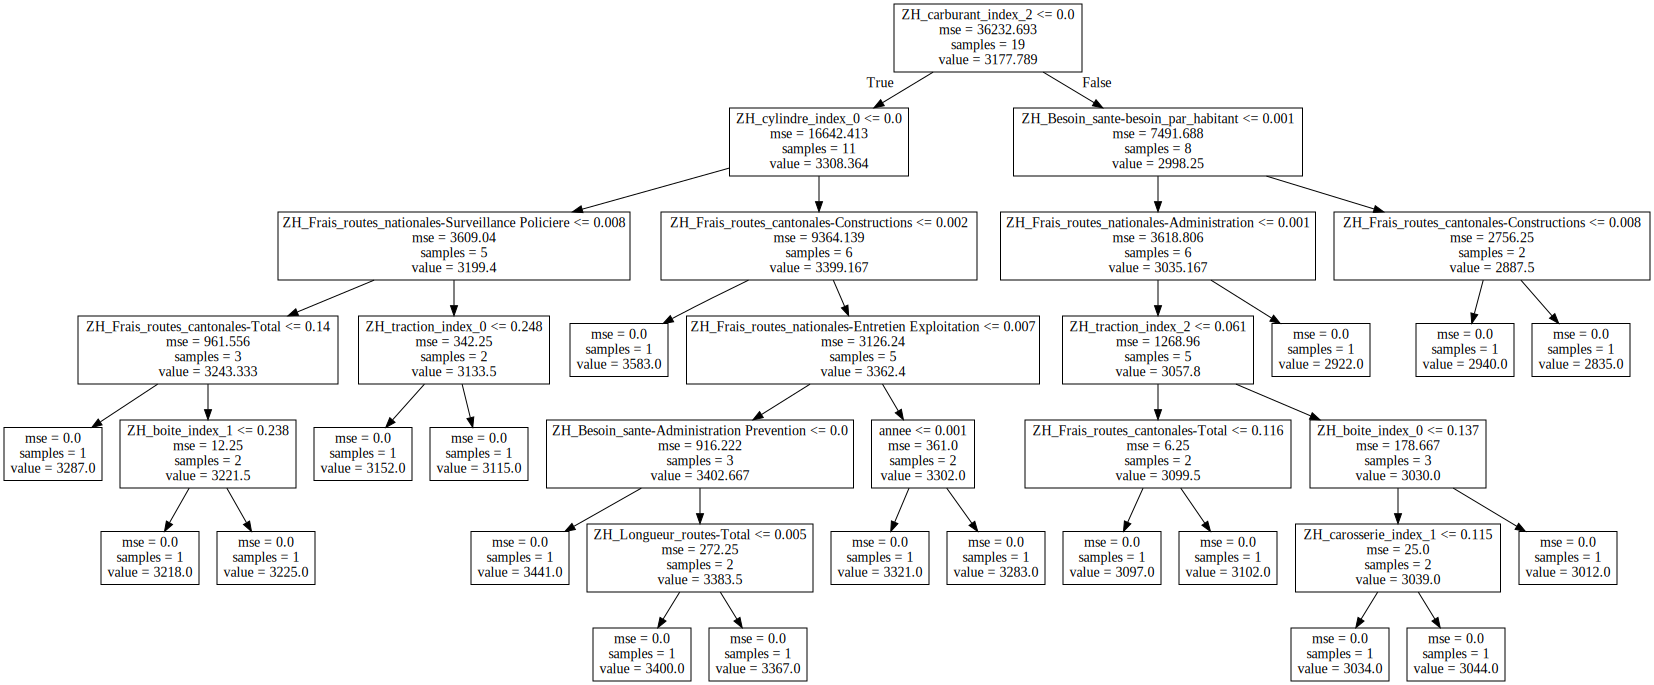

In [244]:
import graphviz
# To see the tree decision of a canton
canton = 'ZH'

clf = ML_stuff['tree']
X = normalize(features_cantons[canton].values)
        
clf.fit(X[:-1],accidents_cantons[canton][:-1])

tree = export_graphviz(clf,out_file=None,feature_names=features_cantons[canton].columns)

 
graphviz.Source(tree)

## 4. Conclusion

Our recommendations to decision makers based on the results of the study!